# ML-QuIC Demonstration Notebook

### Metrics Quick Reference
Accuracy = % correct
Precision = % identified positive which actually were
Recall = % of positive samples identified

## Universal Import of Data and Packages

In [1]:
### Import Packages
import importlib as imp
import ML_QuIC as ML_QuIC
imp.reload(ML_QuIC)
import copy
import numpy as np
import tensorflow as tf

In [2]:
### Import Data and Create Objects to Analyze
DATA_DIR = '../Data/BigAnalysis'
RANDOM_SEED = 7

# Load data
ml_quic = ML_QuIC.ML_QuIC()
ml_quic.import_dataset(data_dir=DATA_DIR)
stats = ml_quic.get_dataset_statistics()

Loading Data from ../Data/BigAnalysis
---- Dataset Label Distribution ----
Negative Samples: 7275
False Positive Samples: 264
Positive Samples: 1273

---- Well Content Distribution: ----
Data Wells: 7828
Control Wells: 984


## Unsupervised - Raw Data
### KMeans

In [3]:
### KMeans
from Models import KMeansModel

ml_quic.add_model(KMeansModel.KMeansModel(), model_name='KMeans', data_type='raw', tag = 'Unsupervised')

### Spectral Clustering

In [4]:
### Spectral Clustering
from Models import SpectralClustering

ml_quic.add_model(SpectralClustering.SpectralClustering(n_vars=8), model_name='Spectral', data_type='raw', tag = 'Unsupervised')

### Train and Compare Unsupervised Models

KMeans:
              precision    recall  f1-score   support

         neg       0.92      0.99      0.95      7539
         pos       0.93      0.47      0.63      1273

    accuracy                           0.92      8812
   macro avg       0.92      0.73      0.79      8812
weighted avg       0.92      0.92      0.91      8812

Spectral:
              precision    recall  f1-score   support

         neg       1.00      0.65      0.79      7539
         pos       0.33      0.99      0.49      1273

    accuracy                           0.70      8812
   macro avg       0.66      0.82      0.64      8812
weighted avg       0.90      0.70      0.75      8812

-------- Results on False Positives for KMeans --------
Accuracy on False Positives: 0.8295454545454546
False Positives Account for 6.28% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 21.783333333333335
Average RAF: 0.059141012288888885
Average MPR: 18.739282945333336
Average MS: 170

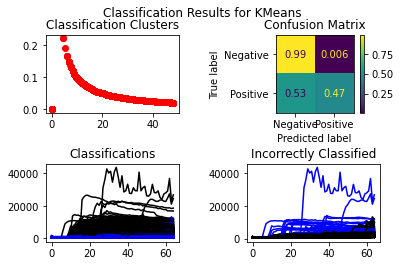

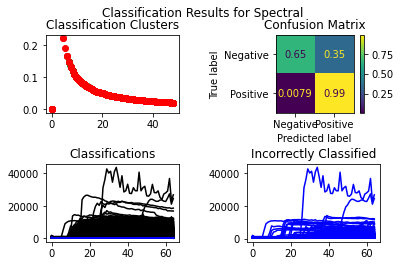

In [5]:
### Get Unsupervised Scores and Plots
ml_quic.separate_train_test(tags=['Unsupervised'], train_type=3)
ml_quic.train_models(tags=['Unsupervised'])
ml_quic.get_model_scores(tags=['Unsupervised'])
ml_quic.evaluate_fp_performance(tags=['Unsupervised'])
ml_quic.get_model_plots(tags=['Unsupervised'])

## Supervised - Raw Data

### Multilayer Perceptron

In [7]:
### MLP
from Models import MLP as MLP
imp.reload(MLP)

# Add MLP to list of supervised models
class_weight = {
    0: max(stats[:3]) / stats[0],
    1: max(stats[:3]) / stats[1] ,
    2: max(stats[:3]) / stats[2]
}
# print(class_weight)

ml_quic.add_model(MLP.MLP(NDIM = ml_quic.get_num_timesteps_raw(), class_weight= class_weight), model_name = 'MLP', data_type = 'raw', tag='Supervised')

### Support Vector Machine

In [8]:
### SVM
from Models import SVM
imp.reload(SVM)

# Add SVM to list of supervised models
ml_quic.add_model(SVM.SVM(), model_name = 'SVM', data_type = 'raw', tag = 'Supervised')

### Train and Compare Supervised Models

In [9]:
### Train Supervised Models
ml_quic.separate_train_test(tags=['Supervised'], train_type=0)
ml_quic.train_models(tags = ['Supervised'])

28/28 [==============================] - 0s 1ms/step
MLP:
              precision    recall  f1-score   support

         neg       1.00      0.97      0.98       753
         pos       0.85      1.00      0.92       128

    accuracy                           0.97       881
   macro avg       0.92      0.98      0.95       881
weighted avg       0.98      0.97      0.97       881

SVM:
              precision    recall  f1-score   support

         neg       0.98      0.97      0.98       753
         pos       0.85      0.91      0.88       128

    accuracy                           0.96       881
   macro avg       0.92      0.94      0.93       881
weighted avg       0.96      0.96      0.96       881

-------- Results on False Positives for MLP --------
28/28 [==============================] - 0s 1ms/step
Accuracy on False Positives: 0.21428571428571427
False Positives Account for 95.65% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 32.

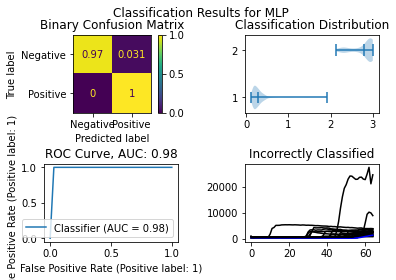

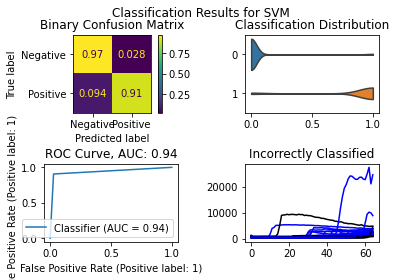

In [10]:
### Get Supervised Scores and Plots
ml_quic.get_model_scores(tags = ['Supervised'])
ml_quic.evaluate_fp_performance(tags=['Supervised'])
ml_quic.get_model_plots(tags=['Supervised'])

In [11]:
ml_quic.models['MLP'].model.save('../MLP2.keras')
ml_quic.models['MLP'].model.save('../MLP2.h5')

## Feature Threshold Analysis
### Selecting Most Important Time Steps

Text(0.5, 0, 'Timestep')

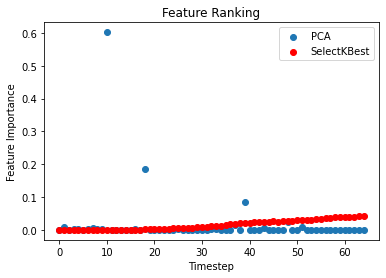

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

x = StandardScaler().fit_transform(ml_quic.get_numpy_dataset('raw'))
y = ml_quic.get_numpy_dataset('labels')

pca = PCA().fit(x)
skb = SelectKBest(k = 'all').fit(x, y)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
features = pca.explained_variance_ratio_[most_important]

plt.scatter(np.arange(len(features)), features)
plt.scatter(np.arange(len(features)), skb.scores_ / (np.sum(skb.scores_)), c='r')
plt.legend(['PCA', 'SelectKBest'])
plt.title('Feature Ranking')
plt.ylabel('Feature Importance')
plt.xlabel('Timestep')

## Unsupervised - Analysis

### Create New Object

In [ ]:
raw_ml_quic = copy.copy(ml_quic)
ml_quic = ML_QuIC.ML_QuIC()
ml_quic.import_dataset(data_dir=DATA_DIR);

Loading Data from ../Data/BigAnalysis


### Add KMeans Model

In [ ]:
### Add KMeans to the list of models to test
from Models import KMeansModel
ml_quic.add_model(KMeansModel.KMeansModel(n_clusters = 3), model_name='KMeans', data_type='analysis', tag='Unsupervised')

### Add Spectral Clustering

In [ ]:
from Models import SpectralClustering
ml_quic.add_model(SpectralClustering.SpectralClustering(n_vars=2), model_name='Spectral', data_type='analysis', tag = 'Unsupervised')

### Train and Compare Unsupervised Models

KMeans:
              precision    recall  f1-score   support

         neg       0.93      0.99      0.96      7539
         pos       0.87      0.59      0.70      1273

    accuracy                           0.93      8812
   macro avg       0.90      0.79      0.83      8812
weighted avg       0.93      0.93      0.92      8812



c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral:
              precision    recall  f1-score   support

         neg       1.00      0.44      0.61      7539
         pos       0.23      1.00      0.37      1273

    accuracy                           0.52      8812
   macro avg       0.62      0.72      0.49      8812
weighted avg       0.89      0.52      0.57      8812

-------- Results on False Positives for KMeans --------
Accuracy on False Positives: 0.5757575757575758
False Positives Account for 17.67% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 34.01482142857143
Average RAF: 0.03324070101785714
Average MPR: 8.606184262651785
Average MS: 743.4508928571429
Correctly Classified FP Characteristics:
Average Time to Threshold: 35.47967105263158
Average RAF: 0.03466472575657895
Average MPR: 8.119295819802632
Average MS: 577.7532894736842
-------- Results on False Positives for Spectral --------


c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Accuracy on False Positives: 0.0
False Positives Account for 5.87% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 34.8582196969697
Average RAF: 0.03406059404924243
Average MPR: 8.325854553132576
Average MS: 648.0492424242424
Correctly Classified FP Characteristics:
Average Time to Threshold: nan
Average RAF: nan
Average MPR: nan
Average MS: nan
-------- Positive Characteristics for Reference --------
Time To Threshold:
	Min: 4.5, Average: 24.424414768263944, Max: 48.0
RAF:
	Min: 0.020833333, Average: 0.048363688274941086, Max: 0.222222222
MPR:
	Min: 1.241918665, Average: 10.765146606306365, Max: 56.55471698
MS:
	Min: 48.75, Average: 841.158483896308, Max: 5967.75


c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


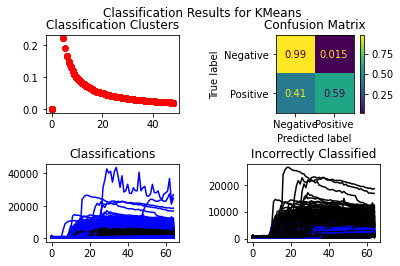

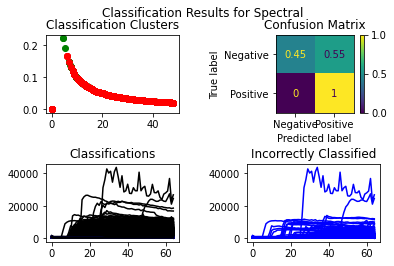

In [ ]:
### Get Unsupervised Scores and Plots
ml_quic.separate_train_test(tags = ['Unsupervised'], train_type=3)
ml_quic.train_models(tags=['Unsupervised'])
ml_quic.get_model_scores(tags=['Unsupervised'])
ml_quic.evaluate_fp_performance(tags=['Unsupervised'])
ml_quic.get_model_plots(tags=['Unsupervised'])

### Add Supervised Learning Technique (SVM)

In [ ]:
### SVM
from Models import SVM
imp.reload(SVM)

# Add SVM to list of supervised models
ml_quic.add_model(SVM.SVM(), model_name = 'SVM', data_type = 'analysis', tag = 'Supervised')

In [ ]:
### Train Supervised Models
ml_quic.separate_train_test(tags=['Supervised'], train_type=0)
ml_quic.train_models(tags = ['Supervised'])

SVM:
              precision    recall  f1-score   support

         neg       1.00      0.97      0.99       767
         pos       0.85      0.98      0.91       114

    accuracy                           0.98       881
   macro avg       0.92      0.98      0.95       881
weighted avg       0.98      0.98      0.98       881

-------- Results on False Positives for SVM --------
Accuracy on False Positives: 0.047619047619047616
False Positives Account for 90.91% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 36.208
Average RAF: 0.03192943420000001
Average MPR: 7.231986225050001
Average MS: 660.375
Correctly Classified FP Characteristics:
Average Time to Threshold: 44.25
Average RAF: 0.02259887
Average MPR: 2.958015267
Average MS: 124.5
-------- Positive Characteristics for Reference --------
Time To Threshold:
	Min: 4.5, Average: 24.424414768263944, Max: 48.0
RAF:
	Min: 0.020833333, Average: 0.048363688274941086, Max: 0.222222222
MPR:
	Min:

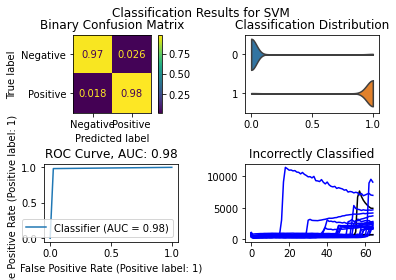

In [ ]:
### Get Supervised Scores and Plots
ml_quic.get_model_scores(tags = ['Supervised'])
ml_quic.evaluate_fp_performance(tags=['Supervised'])
ml_quic.get_model_plots(tags=['Supervised'])